In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [7]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset directory
data_dir = r'C:\Amrita\7TH SEM\PROJECT PHASE - 1\1.2\2 Class'  # Change this path

# Define train, test, and validation paths
train_dir = os.path.join(data_dir, r'C:\Amrita\7TH SEM\PROJECT PHASE - 1\1.2\2 Class\Train')
test_dir = os.path.join(data_dir, r'C:\Amrita\7TH SEM\PROJECT PHASE - 1\1.2\2 Class\Test')
val_dir = os.path.join(data_dir, r'C:\Amrita\7TH SEM\PROJECT PHASE - 1\1.2\2 Class\Val')


Using device: cpu


In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [9]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.classes  # Should be ["Normal", "Abnormal"]
print(f"Classes: {class_names}")


Classes: ['Abnorm', 'Norm']


In [10]:
model = timm.create_model("convnext_tiny", pretrained=True, num_classes=2)
model.to(device)


ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)


In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # Training Phase
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accs.append(correct / total)

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(correct / total)

        epoch_end = time.time()
        elapsed_time = epoch_end - start_time
        remaining_time = (elapsed_time / (epoch + 1)) * (num_epochs - epoch - 1)
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.2f}")
        print(f"Time elapsed: {elapsed_time/60:.2f} min | Estimated remaining: {remaining_time/60:.2f} min")

    return train_losses, val_losses, train_accs, val_accs


In [13]:
num_epochs = 20
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Epoch 1/20 Training: 100%|██████████| 181/181 [12:53<00:00,  4.27s/it]


Epoch 1/20: Train Loss: 0.7244, Train Acc: 0.58, Val Loss: 0.6836, Val Acc: 0.59
Time elapsed: 13.49 min | Estimated remaining: 256.22 min


Epoch 2/20 Training: 100%|██████████| 181/181 [13:48<00:00,  4.58s/it]


Epoch 2/20: Train Loss: 0.6748, Train Acc: 0.60, Val Loss: 0.6905, Val Acc: 0.52
Time elapsed: 27.86 min | Estimated remaining: 250.78 min


Epoch 3/20 Training: 100%|██████████| 181/181 [15:26<00:00,  5.12s/it]


Epoch 3/20: Train Loss: 0.6678, Train Acc: 0.60, Val Loss: 0.6659, Val Acc: 0.62
Time elapsed: 43.99 min | Estimated remaining: 249.25 min


Epoch 4/20 Training: 100%|██████████| 181/181 [15:47<00:00,  5.23s/it]


Epoch 4/20: Train Loss: 0.6596, Train Acc: 0.60, Val Loss: 0.6401, Val Acc: 0.62
Time elapsed: 60.45 min | Estimated remaining: 241.82 min


Epoch 5/20 Training: 100%|██████████| 181/181 [15:49<00:00,  5.25s/it]


Epoch 5/20: Train Loss: 0.5531, Train Acc: 0.71, Val Loss: 0.4954, Val Acc: 0.74
Time elapsed: 76.96 min | Estimated remaining: 230.88 min


Epoch 6/20 Training: 100%|██████████| 181/181 [15:47<00:00,  5.23s/it]


Epoch 6/20: Train Loss: 0.4140, Train Acc: 0.81, Val Loss: 0.4228, Val Acc: 0.80
Time elapsed: 93.42 min | Estimated remaining: 217.98 min


Epoch 7/20 Training: 100%|██████████| 181/181 [15:47<00:00,  5.23s/it]


Epoch 7/20: Train Loss: 0.3484, Train Acc: 0.85, Val Loss: 0.4837, Val Acc: 0.79
Time elapsed: 109.89 min | Estimated remaining: 204.08 min


Epoch 8/20 Training: 100%|██████████| 181/181 [15:51<00:00,  5.26s/it]


Epoch 8/20: Train Loss: 0.2558, Train Acc: 0.90, Val Loss: 0.4863, Val Acc: 0.80
Time elapsed: 126.45 min | Estimated remaining: 189.68 min


Epoch 9/20 Training: 100%|██████████| 181/181 [16:36<00:00,  5.50s/it]


Epoch 9/20: Train Loss: 0.1757, Train Acc: 0.93, Val Loss: 0.5988, Val Acc: 0.79
Time elapsed: 143.78 min | Estimated remaining: 175.73 min


Epoch 10/20 Training: 100%|██████████| 181/181 [15:50<00:00,  5.25s/it]


Epoch 10/20: Train Loss: 0.1366, Train Acc: 0.95, Val Loss: 0.6102, Val Acc: 0.77
Time elapsed: 160.29 min | Estimated remaining: 160.29 min


Epoch 11/20 Training: 100%|██████████| 181/181 [15:48<00:00,  5.24s/it]


Epoch 11/20: Train Loss: 0.0972, Train Acc: 0.97, Val Loss: 0.6607, Val Acc: 0.80
Time elapsed: 176.77 min | Estimated remaining: 144.63 min


Epoch 12/20 Training: 100%|██████████| 181/181 [15:48<00:00,  5.24s/it]


Epoch 12/20: Train Loss: 0.0559, Train Acc: 0.98, Val Loss: 0.7354, Val Acc: 0.79
Time elapsed: 193.27 min | Estimated remaining: 128.84 min


Epoch 13/20 Training: 100%|██████████| 181/181 [15:48<00:00,  5.24s/it]


Epoch 13/20: Train Loss: 0.0701, Train Acc: 0.97, Val Loss: 1.0005, Val Acc: 0.77
Time elapsed: 209.75 min | Estimated remaining: 112.94 min


Epoch 14/20 Training: 100%|██████████| 181/181 [15:48<00:00,  5.24s/it]


Epoch 14/20: Train Loss: 0.0478, Train Acc: 0.98, Val Loss: 0.7266, Val Acc: 0.79
Time elapsed: 226.25 min | Estimated remaining: 96.96 min


Epoch 15/20 Training: 100%|██████████| 181/181 [15:47<00:00,  5.23s/it]


Epoch 15/20: Train Loss: 0.0406, Train Acc: 0.99, Val Loss: 0.7139, Val Acc: 0.78
Time elapsed: 242.72 min | Estimated remaining: 80.91 min


Epoch 16/20 Training: 100%|██████████| 181/181 [15:48<00:00,  5.24s/it]


Epoch 16/20: Train Loss: 0.0399, Train Acc: 0.99, Val Loss: 0.7105, Val Acc: 0.80
Time elapsed: 259.21 min | Estimated remaining: 64.80 min


Epoch 17/20 Training: 100%|██████████| 181/181 [15:47<00:00,  5.24s/it]


Epoch 17/20: Train Loss: 0.0250, Train Acc: 0.99, Val Loss: 1.2057, Val Acc: 0.79
Time elapsed: 275.68 min | Estimated remaining: 48.65 min


Epoch 18/20 Training: 100%|██████████| 181/181 [15:45<00:00,  5.23s/it]


Epoch 18/20: Train Loss: 0.0274, Train Acc: 0.99, Val Loss: 0.9499, Val Acc: 0.78
Time elapsed: 292.13 min | Estimated remaining: 32.46 min


Epoch 19/20 Training: 100%|██████████| 181/181 [15:48<00:00,  5.24s/it]


Epoch 19/20: Train Loss: 0.0222, Train Acc: 0.99, Val Loss: 0.9543, Val Acc: 0.79
Time elapsed: 308.62 min | Estimated remaining: 16.24 min


Epoch 20/20 Training: 100%|██████████| 181/181 [15:46<00:00,  5.23s/it]


Epoch 20/20: Train Loss: 0.0284, Train Acc: 0.99, Val Loss: 1.2561, Val Acc: 0.78
Time elapsed: 325.08 min | Estimated remaining: 0.00 min


In [14]:
save_path = r"C:\Amrita\7TH SEM\PROJECT PHASE - 1\1.2\Models\ConvNeXt_Model_2Class.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved at: {save_path}")


Model saved at: C:\Amrita\7TH SEM\PROJECT PHASE - 1\1.2\Models\ConvNeXt_Model_2Class.pth


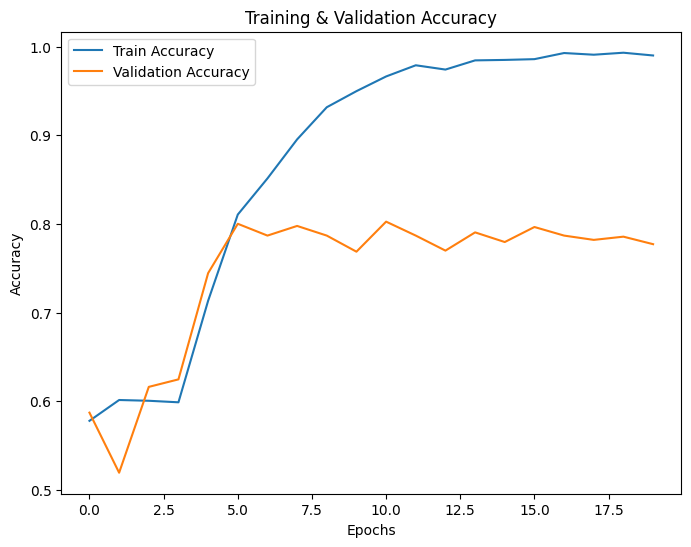

In [15]:
plt.figure(figsize=(8,6))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.show()


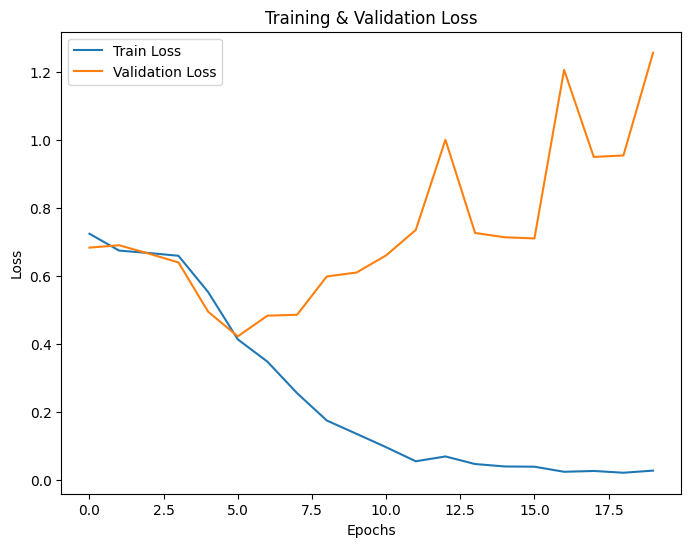

In [16]:
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()


In [17]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [18]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="binary")
recall = recall_score(y_true, y_pred, average="binary")
f1 = f1_score(y_true, y_pred, average="binary")

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.81
Precision: 0.75
Recall: 0.74
F1 Score: 0.75


In [19]:
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names, digits=2))



Classification Report:
               precision    recall  f1-score   support

      Abnorm       0.84      0.84      0.84      1017
        Norm       0.75      0.74      0.75       639

    accuracy                           0.81      1656
   macro avg       0.80      0.79      0.80      1656
weighted avg       0.81      0.81      0.81      1656



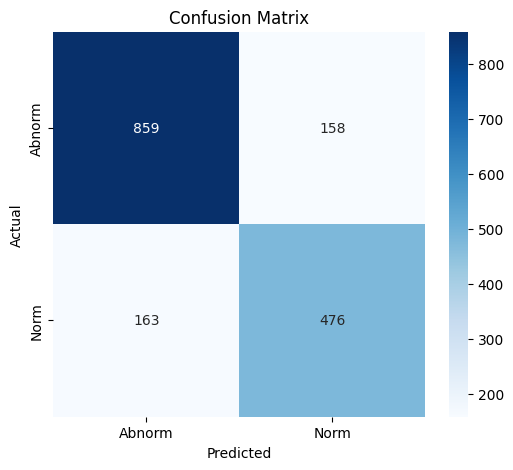

In [20]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
